In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from numpy import loadtxt
from tensorflow.keras import layers
import spektral
import os
import scipy.sparse as sp
import tensorflow as tf
import tensorflow.keras as keras

In [2]:
bus = 73
samples = 20000
nLabel = 2
level = 95

Bus_data = loadtxt('BusData.dat')
Gen_data = loadtxt('GenData.dat')
Bra_data = loadtxt('BranchData.dat')

PD = loadtxt(('Pd_Profile_%d.csv' %bus), delimiter=',')   #Load Profile
PF = loadtxt(('PF_Profile_%d.csv' %bus), delimiter=',')   #Branch Profile
Pg = loadtxt(('Pg_Profile_%d.csv' %bus), delimiter=',')   #Generation Profile
TC = loadtxt(('TC_Profile_%d.csv' %bus), delimiter=',')   #Total Cost 

branch = Bra_data.shape[0]

In [3]:
# Sum up the total amount of generation capacity and cost per bus
Pg_Cap = np.zeros([bus,2])
for i in range(bus):
    index = np.nonzero(Gen_data[:,2] == Bus_data[i,1])
    Pg_Cap[i] = np.sum(np.squeeze(Gen_data[index,3:5]),axis = 0)

In [4]:
# Create label for graph

Label = np.zeros([samples,PF.shape[1]])
PF_Percent = PF / Bra_data[:,5]

# Label each branch as either 1, 2, 3 or 4
Label = (np.abs(PF_Percent) >= level/100 ) * 1 #+ \
# np.all([(np.abs(PF_Percent) <= 0.95),(np.abs(PF_Percent) > 0.75)], axis = 0) * 2 + \
# (np.abs(PF_Percent) > 0.95) * 3
# np.all([(np.abs(PF_Percent) <= 0.95),(np.abs(PF_Percent) > 0.85)], axis = 0) * 3 + \

# Convert label to one hot encoding
Label = tf.one_hot(Label, depth = nLabel)

In [5]:
# Create Edge features
EF = np.zeros([samples,branch,3])
EF[:,:,0] = Bra_data[:,4]        #Reactant
EF[:,:,1] = Bra_data[:,5]        #Line Limit
EF[:,:,2] = Bra_data[:,6]        #Number of parallel lines
EF = EF

# Create Node features
NF = np.zeros([samples,bus,5])
NF[:,:,0]   = PD              #Load Profile
NF[:,:,1:3] = Pg_Cap          #Generator Profile
node = np.zeros([bus])
for i in range(bus):
    node[i] = np.sum( Bra_data[:,2]-1 == i) + np.sum( Bra_data[:,3]-1 == i)
NF[:,:,3] = node              #Number of branches connect to each node
NF[:,:,4] = Bus_data[:,3]     #Bus Type
# NF[:,:,1]   = Pg_Bus
NF = NF

In [6]:
#Build CNN model
from tensorflow.keras.layers import Dense, Dropout, Conv1D, PReLU
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD


class CNN(Model):
    def __init__(self):
        super().__init__()
        
        #Convolution for node features
        self.con1N = Conv1D(20, 1, activation='PReLU')
        self.con2N = Conv1D(40, 1, activation='PReLU')
        self.con3N = Conv1D(80, 1, activation='PReLU')
        self.con4N = Conv1D(branch, 1, activation='PReLU')
        
        #Convolution for edge features
        self.con1E = Conv1D(12, 1, activation='PReLU')
        self.con2E = Conv1D(24, 1, activation='PReLU')
        self.con3E = Conv1D(48, 1, activation='PReLU')
        self.con4E = Conv1D(bus, 1, activation='PReLU')   

        # self.drop  = Dropout(0.15)
        self.dense = Dense(nLabel, activation="softmax")

    def call(self, x, e):
        x    = self.con1N(x)
        x    = self.con2N(x)
        x    = self.con3N(x)
        x    = self.con4N(x)        
        
        e    = self.con1E(e)
        e    = self.con2E(e)
        e    = self.con3E(e)
        e    = self.con4E(e)

        output = self.dense(e + np.transpose(x,(0,2,1)))
        return output

model = CNN()


In [7]:
################################################################################
# Config
################################################################################
learning_rate = 0.001  # Learning rate
epochs = 250  # Number of training epochs
es_patience = 75  # Patience for early stopping
batch_size = 250  # Batch size
optimizer = Adam(learning_rate=learning_rate)
# optimizer = SGD(learning_rate=learning_rate, momentum=0.7, nesterov=False,name='SGD')
loss_fn = CategoricalCrossentropy()

In [8]:
# Train/valid/test split
idxs = range(samples) #np.random.permutation(len(data))
split_va, split_te = int(0.8 * samples), int(0.9 * samples)
idx_tr, idx_va, idx_te = np.split(idxs, [split_va, split_te])

# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((tf.gather(NF,idx_tr), tf.gather(EF,idx_tr), tf.gather(Label,idx_tr)))
train_dataset = train_dataset.shuffle(split_va).batch(batch_size)

# Prepare the validation dataset.
val_dataset   = tf.data.Dataset.from_tensor_slices((tf.gather(NF,idx_va), tf.gather(EF,idx_va), tf.gather(Label,idx_va)))
val_dataset   = val_dataset.batch(int(0.1 * samples))

# Prepare the test dataset.
test_dataset  = tf.data.Dataset.from_tensor_slices((tf.gather(NF,idx_te), tf.gather(EF,idx_te), tf.gather(Label,idx_te)))
test_dataset  = test_dataset.batch(int(0.1 * samples))

In [9]:
def evaluate(loader):
    for step, (x_val, e_val, y_val) in enumerate(loader):
        targ_va = y_val
        pred_va = model(x_val, e_val, training=False)
    return pred_va, targ_va

In [10]:
epoch = step = 0
best_val_loss = np.inf
best_weights = None
patience = es_patience
results = []
step = 0
track = np.zeros([epochs,4])

for epoch in range(epochs):
    for step, (x_train, e_train, y_train) in enumerate(train_dataset):
        
        
        # loss, acc = train_step(*batch)
        target = y_train
        with tf.GradientTape() as tape:
            prediction = model(x_train, e_train, training=True)
            loss = loss_fn(target, prediction) + sum(model.losses)
        gradients = tape.gradient(loss, model.trainable_variables, unconnected_gradients=tf.UnconnectedGradients.ZERO) #UnconnectedGradients.NONE
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        acc = tf.reduce_mean(categorical_accuracy(target, prediction))
        results.append((loss, acc))
    
        #Print out result after every epoch
        if step == 0:#loader_tr.steps_per_epoch: 

            # Compute validation loss and accuracy            
            val_prediction, val_target = evaluate(val_dataset)
            val_loss = loss_fn(val_target, val_prediction),
            val_acc = tf.reduce_mean(categorical_accuracy(val_target, val_prediction))

            #Save loss and accuracy for plotting
            track[epoch,:] = [ *np.mean(results, 0), *val_loss, val_acc.numpy() ]   
            
            step = 0
            epoch += 1        
            # Print out result for each epoch
            print(
                "Ep. {} - Loss: {:.5f} - Acc: {:.5f} - Val loss: {:.5f} - Val acc: {:.5f}".format(
                    epoch, *np.mean(results, 0), *val_loss, val_acc.numpy()
                )
            )

            # Check if loss improved for early stopping
            if val_loss[0] < best_val_loss:
                best_val_loss = val_loss
                patience = es_patience
                print("New best val_loss {:.3f}".format(*val_loss))
                best_weights = model.get_weights()
            else:
                patience -= 1
                if patience == 0:
                    print("Early stopping (best val_loss: {})".format(best_val_loss))
                    break
            results = []

################################################################################
# Evaluate model
################################################################################
model.set_weights(best_weights)  # Load best model

Ep. 1 - Loss: 73.44574 - Acc: 0.11907 - Val loss: 64.38474 - Val acc: 0.11894
New best val_loss 64.385
Ep. 2 - Loss: 7.53206 - Acc: 0.77657 - Val loss: 0.25810 - Val acc: 0.95733
New best val_loss 0.258
Ep. 3 - Loss: 0.12565 - Acc: 0.96081 - Val loss: 0.08160 - Val acc: 0.96229
New best val_loss 0.082
Ep. 4 - Loss: 0.08067 - Acc: 0.96196 - Val loss: 0.07882 - Val acc: 0.96227
New best val_loss 0.079
Ep. 5 - Loss: 0.07927 - Acc: 0.96204 - Val loss: 0.07838 - Val acc: 0.96196
New best val_loss 0.078
Ep. 6 - Loss: 0.07909 - Acc: 0.96195 - Val loss: 0.07794 - Val acc: 0.96212
New best val_loss 0.078
Ep. 7 - Loss: 0.07881 - Acc: 0.96194 - Val loss: 0.07785 - Val acc: 0.96215
New best val_loss 0.078
Ep. 8 - Loss: 0.07871 - Acc: 0.96192 - Val loss: 0.07760 - Val acc: 0.96209
New best val_loss 0.078
Ep. 9 - Loss: 0.07848 - Acc: 0.96202 - Val loss: 0.07752 - Val acc: 0.96264
New best val_loss 0.078
Ep. 10 - Loss: 0.07846 - Acc: 0.96205 - Val loss: 0.07748 - Val acc: 0.96254
New best val_loss 0.

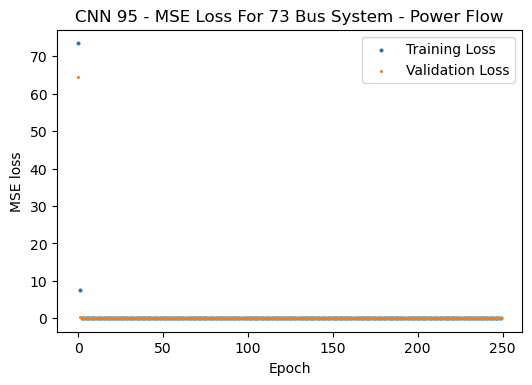

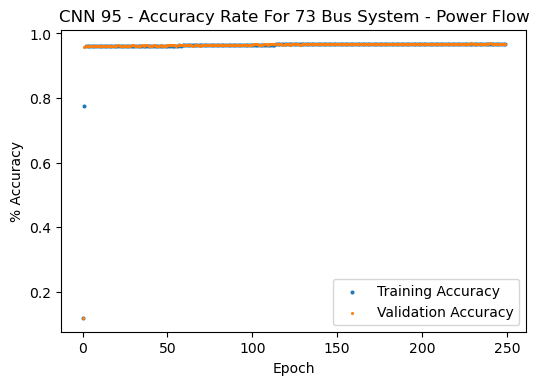

In [11]:
# Plot the result  
plt.figure(dpi=100)       
plt.scatter(range(epochs),track[:,0], label = "Training Loss", marker ="8", s = 4)
plt.scatter(range(epochs),track[:,2], label = "Validation Loss", marker = ".", s = 6)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.title('CNN {} - MSE Loss For {} Bus System - Power Flow'.format(level, bus))
plt.savefig("Plot/CNN_{}_Loss_{}.png".format(level, bus))

plt.figure(dpi=100) 
plt.scatter(range(epochs),track[:,1], label = "Training Accuracy", marker ="8", s = 4)
plt.scatter(range(epochs),track[:,3], label = "Validation Accuracy", marker = ".", s = 6)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel("% Accuracy")
plt.title('CNN {} - Accuracy Rate For {} Bus System - Power Flow'.format(level, bus))
plt.savefig("Plot/CNN_{}_Accuracy_{}.png".format(level, bus))

In [12]:
#Evaluate test dataset
test_prediction, test_target = evaluate(test_dataset)

In [13]:
#Round up the highest probability value to 1, all other probability values are set to 0
def max_prob(probability):
    prob = probability.numpy()
    max_val = np.amax(prob,2,keepdims=1)
    prob[prob != max_val] = 0
    prob[prob == max_val] = 1
    return prob

#Find the error rate of final prediction
def err_rate(preds,targs):
    diff_rate = targs - preds
    x, y, z = diff_rate.shape
    diff_rate[diff_rate == 1] = 0
    return np.sum(np.abs(diff_rate)) / (x * y)

# # Find which categories and which branches are misidentified the most for 3 categories
# def err_stat(preds,targs):
#     diff_rate = targs - preds
    
#     x, y, z = diff_rate.shape 
#     cat = np.array([ [1, -1, 0] , [1, 0, -1] , [0, 1, -1] , [-1, 1, 0] , [0, -1, 1] , [-1, 0, 1] ])
#     err = np.zeros([diff_rate.shape[0],diff_rate.shape[1],6])
#     for i in range(diff_rate.shape[0]): 
#         for j in range(diff_rate.shape[1]): 
#             for k in range(6):        
#                 err[i,j,k] = np.array_equiv(cat[k],diff_rate[i,j])
#     cat_stat = np.sum(np.sum(err,axis = 0),axis = 0)               #Error rate across 6 categories
#     bra_stat = np.sum(np.sum(err,axis = 0),axis = 1)               #Error rate across all branches
#     sam_stat = np.sum(np.sum(err,axis = 1),axis = 1)               #Error rate across number of samples
#     return cat_stat, bra_stat, sam_stat

# Find which categories and which branches are misidentified the most for 2 categories
def err_stat(preds,targs):
    diff_rate = targs - preds
    
    x, y, z = diff_rate.shape 
    cat = np.array([ [1, -1] , [-1, 1] ])
    err = np.zeros([x,y,2])
    for i in range(diff_rate.shape[0]): 
        for j in range(diff_rate.shape[1]): 
            for k in range(2):        
                err[i,j,k] = np.array_equiv(cat[k],diff_rate[i,j])
    cat_stat = np.sum(np.sum(err,axis = 0),axis = 0)               #Error rate across 6 categories
    
    sam_stat = np.sum(np.sum(err,axis = 1),axis = 1)               #Error rate across number of samples
    
    bra1_stat = np.sum(err[:,:,0],axis = 0)                        #Error rate across all branches for category 1
    bra2_stat = -np.sum(err[:,:,1],axis = 0)                       #Error rate across all branches for category 2
    return cat_stat, bra1_stat, bra2_stat, sam_stat, err

In [14]:
#Find the best probability of prediction for test data set:
pred = max_prob(test_prediction)
targ = tf.round(test_target).numpy()

[3920. 2855.]
[  0.   0.   0.   0.   0.   0. 707.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  38.   0.   0.   0.   0.   0.   2.   0.   0.   0.
 631.   0.   0.   0.   0.   0. 366.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  77. 354.   0.
   0.   0.   0.   0.   0.   0.   0.  16.   0.   0.   0.   0.   0. 198.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0. 195. 252.   0.   0.   0.   0.   0.   0.   0.   0. 222.
   0.   0.   0.   0.   0. 862.   0.   0.   0.   0.]
[  -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0. -727.   -0.
   -0.   -0.   -0.   -0.   -0.  -39. -304.   -0.   -0.   -0.   -0.   -0.
   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0. -337.   -0.
   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.
   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.  -22.   -0.   -0.
   -0.  -86.   -0.   -0.   -0.   -0.   -0.   -0.   -0. -359.   -0.   -0.

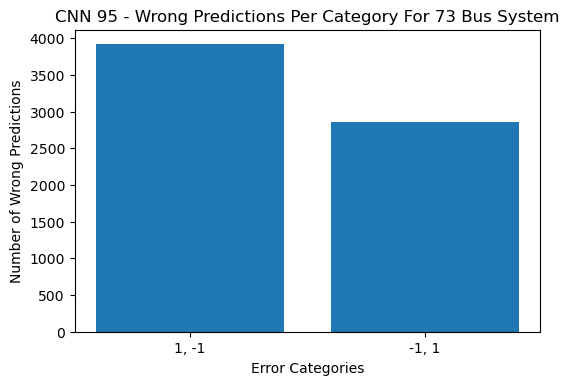

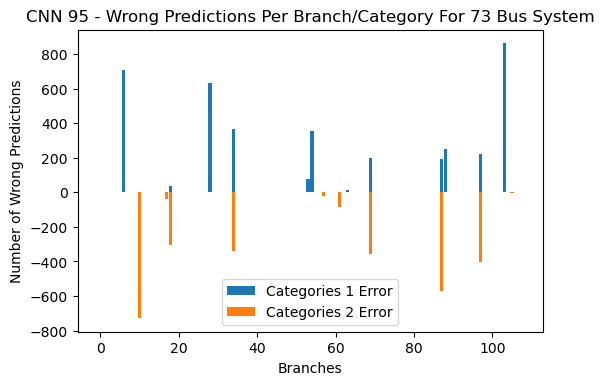

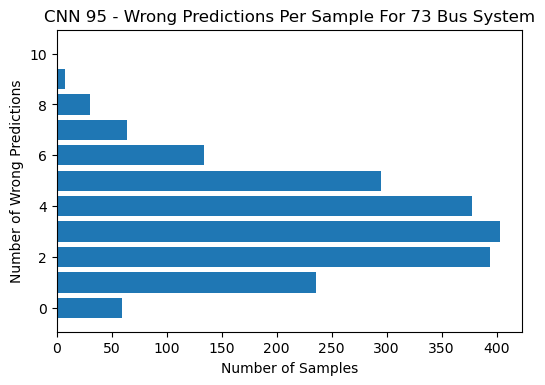

In [15]:
cat_err, bra1_err, bra2_err, sam_err, error = err_stat(pred, targ)

#Plot the number of wrong predictions per categories
# names = [ "1, -1, 0" , "1, 0, -1" , "0, 1, -1" , "-1, 1, 0" , "0, -1, 1" , "-1, 0, 1" ]
names = [ "1, -1" , "-1, 1"]
print(cat_err)
plt.figure(dpi=100)      
plt.bar(names, cat_err)
plt.xlabel('Error Categories')
plt.ylabel("Number of Wrong Predictions")
plt.title('CNN {} - Wrong Predictions Per Category For {} Bus System'.format(level, bus))
plt.savefig("Plot/CNN_{}_Categories_{}.png".format(level, bus))

#Plot the number of wrong predictions per branches
print(bra1_err)
print(bra2_err)
plt.figure(dpi=100) 
plt.bar(range(branch), bra1_err, label ="Categories 1 Error")
plt.bar(range(branch), bra2_err, label ="Categories 2 Error")
plt.legend()
plt.xlabel('Branches')
plt.ylabel("Number of Wrong Predictions")
plt.title('CNN {} - Wrong Predictions Per Branch/Category For {} Bus System'.format(level, bus))
plt.savefig("Plot/CNN_{}_Branches_{}.png".format(level, bus))

#Plot histogram of how many wrong predictions per number of samples
plt.figure(dpi=100) 
plt.hist(sam_err, bins = range(12), align = 'left', rwidth = 0.8, orientation = 'horizontal')
plt.xlabel("Number of Samples")
plt.ylabel("Number of Wrong Predictions")
plt.title('CNN {} - Wrong Predictions Per Sample For {} Bus System'.format(level, bus))
plt.savefig("Plot/CNN_{}_Historgram_{}.png".format(level, bus))

#Total number of wrong predictions and error rates
print('Number of wrong predictions is ', np.sum(cat_err))
print('Error rate is ', err_rate(pred, targ))

In [16]:
#Write prediction result into .csv files
pred_csv = pred
pred_csv[:,:,0] = pred[:,:,0]*1
pred_csv[:,:,1] = pred[:,:,1]*2
# pred_csv[:,:,2] = pred[:,:,2]*3
pred_csv = np.sum(pred_csv, axis = 2)


with open(("Result/CNN_{}_PF_Predict_{}.csv".format(level, bus)), 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',')
    for i in range(pred_csv.shape[0]):
        csv_writer.writerow(pred_csv[i,:])